In [37]:
import numpy as np
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage import exposure

%matplotlib notebook

<IPython.core.display.Javascript object>


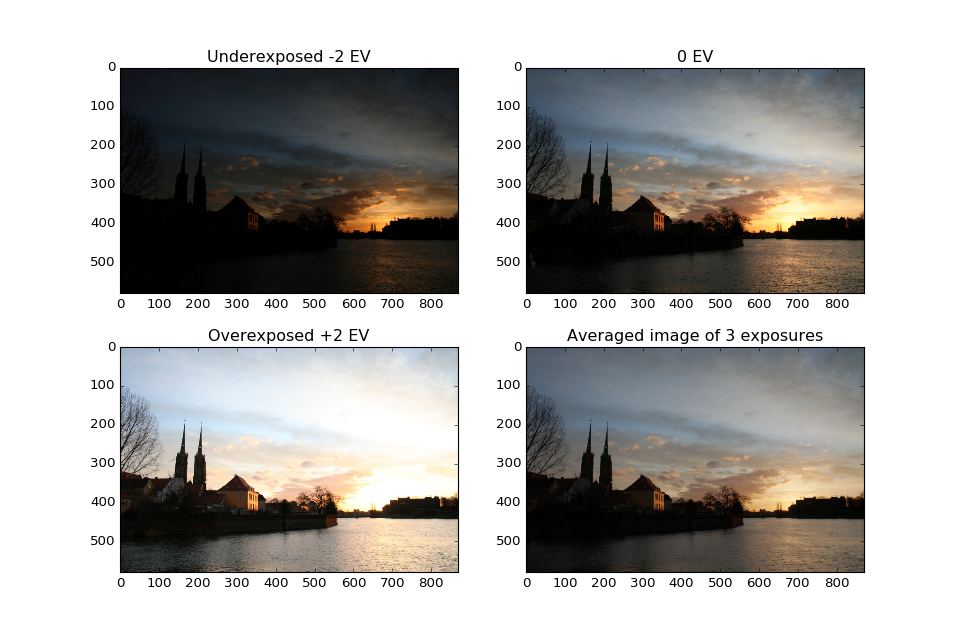

In [39]:
im1 = img_as_float(image.imread("images/ostrow_tumski1.jpg"))
im2 = img_as_float(image.imread("images/ostrow_tumski2.jpg"))
im3 = img_as_float(image.imread("images/ostrow_tumski3.jpg"))
im_orig = image.imread("images/ostrow_tumski.jpg")

# show results of simple averaging
fig = plt.figure(1,figsize=(12,8))

ax1 = plt.subplot(221)
plt.imshow(im1)
plt.title("Underexposed -2 EV")

ax2 = plt.subplot(222)
plt.imshow(im2)
plt.title("0 EV")

ax3 = plt.subplot(223)
plt.imshow(im3)
plt.title("Overexposed +2 EV")

im4 = im1*0.33 + im2*0.33 + im3*0.33
ax4 = plt.subplot(224)
plt.imshow(im4)
plt.title("Averaged image of 3 exposures")

plt.show()

<IPython.core.display.Javascript object>


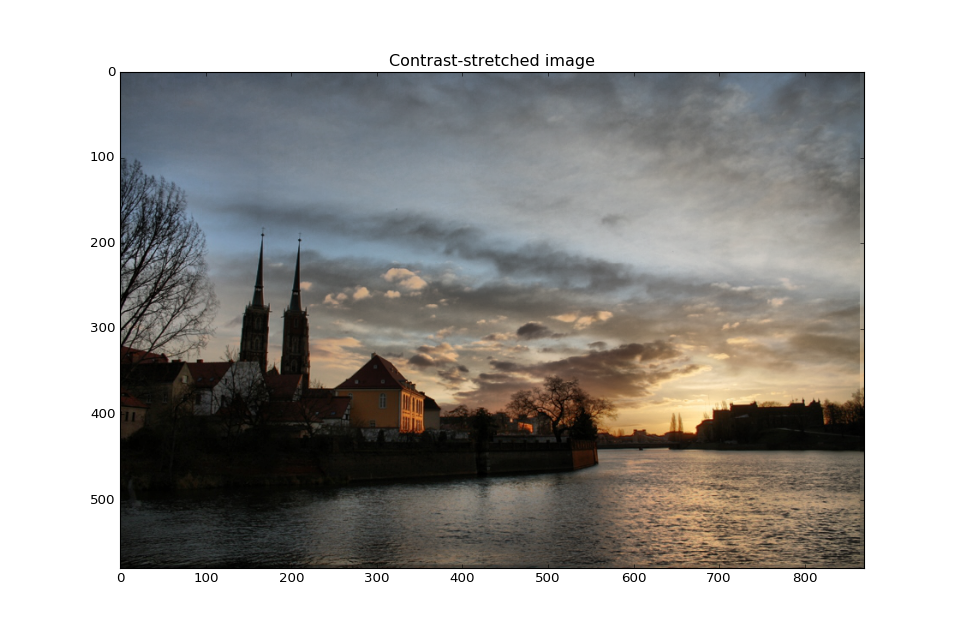

<IPython.core.display.Javascript object>


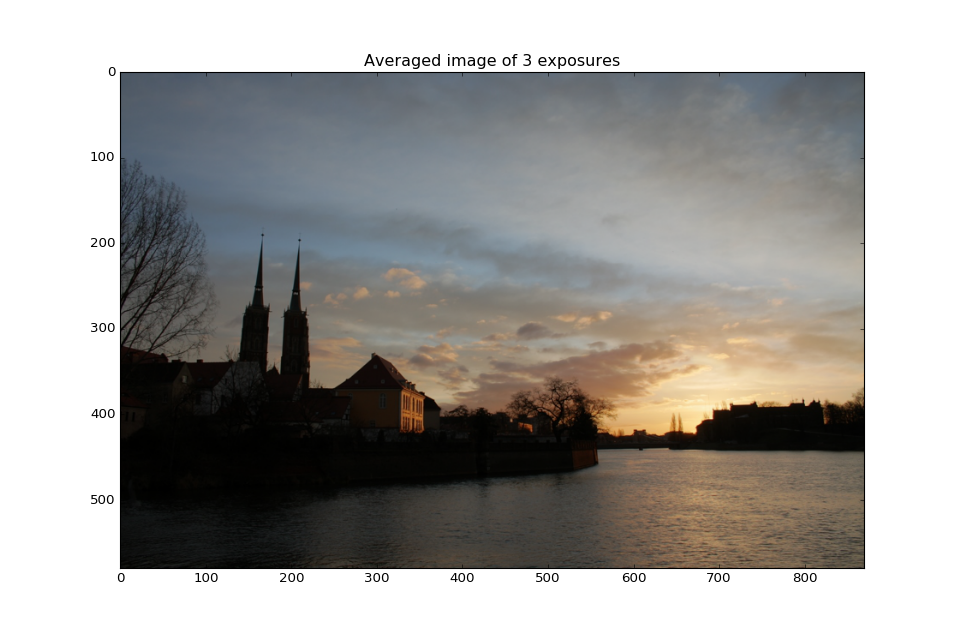

In [43]:
im_adpteq = exposure.equalize_adapthist(im4)
fig = plt.figure(2,figsize=(12,8))
plt.subplot(111)
plt.imshow(im_adpteq)
plt.title("Contrast-stretched image")

plt.figure(3,figsize=(12,8))
plt.subplot(111)
plt.title("Averaged image of 3 exposures")
plt.imshow(im4)

plt.show()

Comparing, the contrast-stretched image to the averaged image, you can clearly see additional detail along the closer shoreline and the sky. However, compared to professional grade HDR, there is a significant difference not only in the visibility and color of the closer shoreline, but also of the farther shoreline (which is now easily visible) as well as in the contrast in the sky

<IPython.core.display.Javascript object>


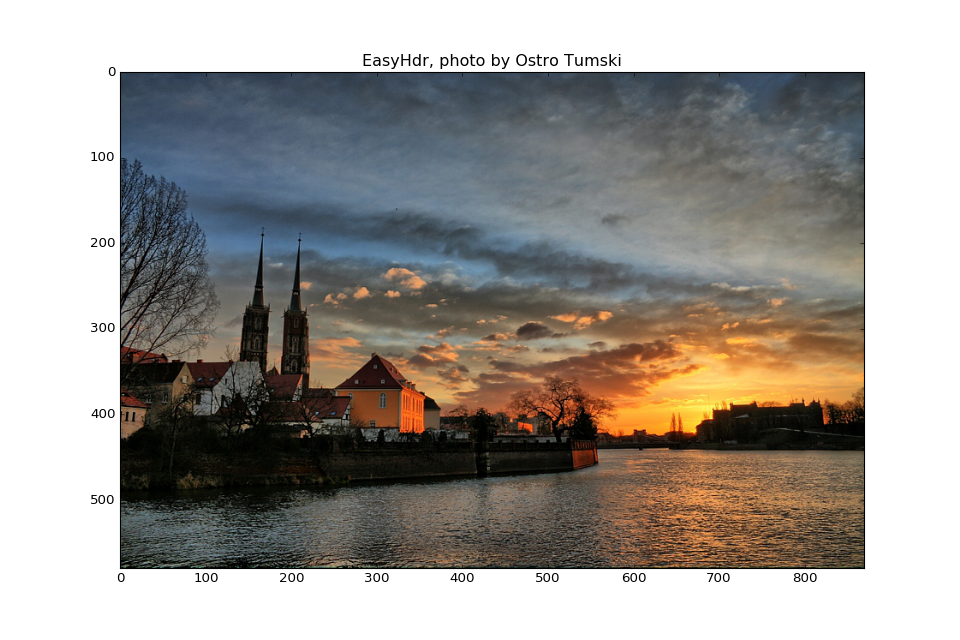

In [44]:
plt.figure(4, figsize=(12,8))
plt.subplot(111)
plt.imshow(im_orig)
plt.title("EasyHdr, photo by Ostro Tumski")
plt.show()